We are going to start with editing photos so they are similar for code to analyse:
- crop them
- make them grey scale
- reduce noise
- edit brightness

In [1]:
import cv2 #opencv -
import matplotlib.pyplot as plt
import numpy as np

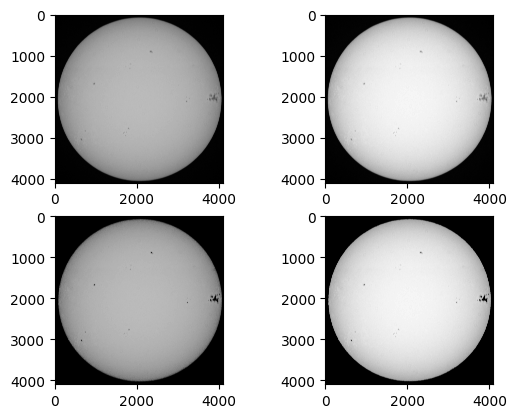

In [2]:

image_original = cv2.imread("SunPhotos/sun.jpg")
image = cv2.cvtColor(image_original, cv2.COLOR_BGR2GRAY)

blur = cv2.GaussianBlur(image, (0,0), sigmaX=33, sigmaY=33)
blurred = cv2.GaussianBlur(image, (5, 5), 0)
equalized_image = cv2.equalizeHist(blurred)
# Binaryzacja - ustawienie progowe (dostosuj wartość progu!)
_, binary = cv2.threshold(image, 100, 255,  cv2.THRESH_TOZERO)
_, binary_blured = cv2.threshold(blurred, 100, 255, cv2.THRESH_TOZERO)



fig = plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(image, cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(blurred, cmap='gray')
plt.subplot(2, 2, 3)
plt.imshow(binary, cmap='gray')
plt.subplot(2, 2, 4)
plt.imshow(binary_blured, cmap='gray')
plt.show()



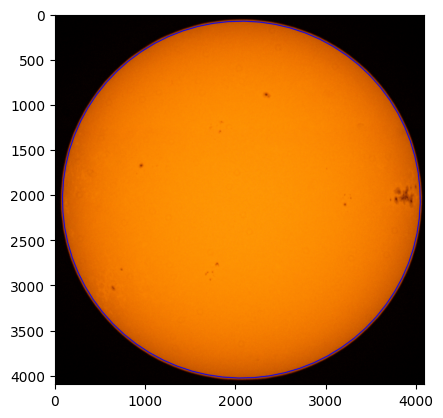

In [3]:
# find all contours
contours, _ = cv2.findContours(binary_blured, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Largest should be sun disk
contours = sorted(contours, key=cv2.contourArea, reverse=True)
if contours:
    largest_contour = contours.pop(0)
else:
    print("No contours found!")
    
# Fit elipse
if len(largest_contour) >= 5: 
    sun_ellipse = cv2.fitEllipse(largest_contour)
    #(center, (major_axis, minor_axis), angle) = cv2.fitEllipse(contour)
    image_elipse = image_original.copy()
    cv2.ellipse(image_elipse, sun_ellipse, (255, 0, 0), 10)  # Rysowanie elipsy
else:
    print("Not enough points for elipse!")
# Show image with blue elipse as a sun disk
plt.imshow(cv2.cvtColor(image_elipse, cv2.COLOR_BGR2RGB))
plt.show()



In [ ]:
if sun_ellipse:  
    #caculate elipse area (in pixels^2)
    (cx, cy), (major_axis, minor_axis), angle = sun_ellipse
    sun_area=np.pi*major_axis/2*minor_axis/2
    
    mask = np.zeros_like(binary) #black mask
    cv2.ellipse(mask, sun_ellipse, 255, -1)  #paint the elipse on mask (full inside, that's why -1)
    masked_binary = cv2.bitwise_and(binary, mask)  #Find contours inside

    inner_contours, _ = cv2.findContours(masked_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)   
    min_area = 50
    max_area = sun_area *0.99
    
    # Filtrowanie małych konturów
    filtered_contours = [cnt for cnt in inner_contours if (cv2.contourArea(cnt) > min_area and cv2.contourArea(cnt) < max_area)]
    filtered_contours.pop(0)
    
    image_contours = image_elipse.copy()
    cv2.drawContours(image_contours, filtered_contours, -1, (0, 255, 0), 5)  # Czerwone kontury

    # Wyświetlenie obrazu
    plt.imshow(cv2.cvtColor(image_contours, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
if filtered_contours:
    spots_area=0
    for contour in filtered_contours:
        spots_area+=cv2.contourArea(contour)
    print(f'Sun spots are on {spots_area/sun_area*100:.3f}% of sun area')